[Common pitfalls in the interpretation of coefficients of linear models](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#sphx-glr-auto-examples-inspection-plot-linear-model-coefficient-interpretation-py)  
This example will provide some hints in **interpreting coefficient** in linear models, pointing at problems that arise when either the linear model is **not appropriate** to describe the dataset, or when features are correlated.

> Note📝  
Keep in mind that the features and the outcomeare in general the result of a data generating process that is unknown to us. Machine learning models are trained to approximate the unobserved mathematical function that links to from sample data. 

We will use data from the <u>“Current Population Survey” </u>from 1985 to **predict wage** as a function of various **features** such as experience, age, or education.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp # ❓
import seaborn as sns

## The dataset:wages

- as_frame: data as pd.df

In [2]:
from sklearn.datasets import fetch_openml
survey = fetch_openml(data_id=534, as_frame=True)

In [3]:
X=survey.data[survey.feature_names]
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


In [4]:
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,35,White,Other,Other,Married


Target for prediction: the wage, float number $/hour.

In [5]:
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42,
)

**First**, let’s get some insights by looking at the variable distributions and at the pairwise relationships between them. (only numerical var.)

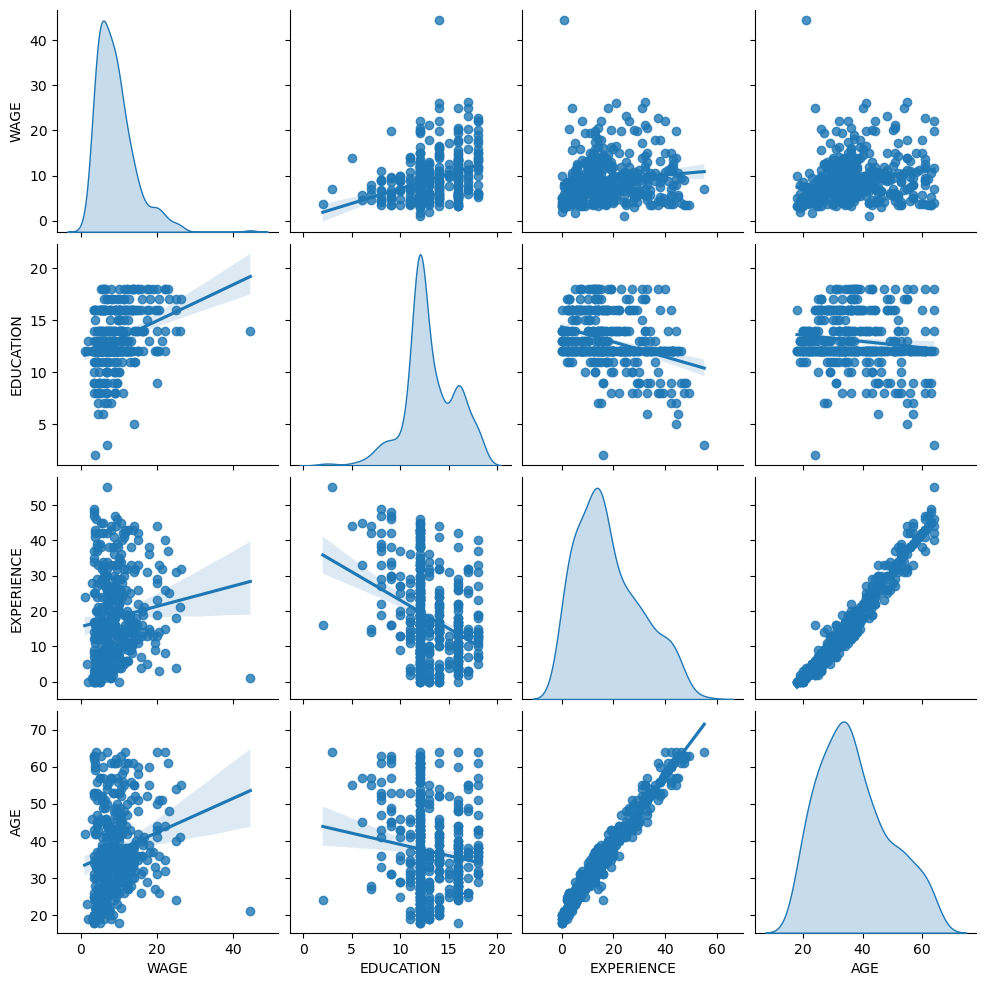

In [8]:
train_dataset = X_train.copy()
train_dataset.insert(0, 'WAGE', y_train)
sns.pairplot(train_dataset, kind='reg', diag_kind='kde')

📈

- Wage distribution has a long tail. We should take its log-alg to turn it into a **approximately normal distribution.**
❓Only target is needed for normal? What's the linear model 假设？如果是离散呢？
- The WAGE is increasing when EDUCATION is increasing. (A marginal dependence)
- Experience and age are strongly linearly correlated.

## The machine-learning pipeline

To design pipeline, first check the type of the data.

In [9]:
survey.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   AGE         534 non-null    int64   
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
dtypes: category(7), int64(3)
memory usage: 17.3 KB


🔍
There are different data types.So we need to apply a specific preprocessing for each data type.
- category: ont-hot-encode
  

In [10]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), categorical_columns), #if_binary will drop one cate-value, remain another one without dealing
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import  TransformedTargetRegressor
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor( # 用于对y变换
        regressor=Ridge(alpha=1e-10),
        func=np.log10, # log化，更加normal
        inverse_func=sp.special.exp10 # inverse
    )
)

## Processing the data

In [12]:
model.fit(X_train, y_train)

d:\miniconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

In [13]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}
print(scores)

{'MedAE on training set': '2.14 $/hour', 'MedAE on testing set': '2.22 $/hour'}


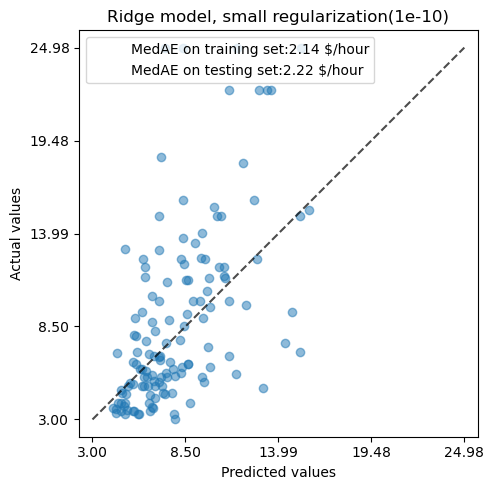

In [14]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, # actual
    y_pred, # pred
    kind="actual_vs_predicted", # picture type
    ax=ax, # 
    scatter_kwargs={"alpha": 0.5} # 
)
ax.set_title("Ridge model, small regularization(1e-10)")
for name, score in scores.items(): # 通过空白图形添加图例
    ax.plot([],[]," ", label =f"{name}:{score}")
ax.legend(loc="upper left")
plt.tight_layout()

Then, we interpret the coef

## Interpreting coefficients: scale matters

First, we can look at the coefficient of the every feature.

In [15]:
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

In [16]:
feature_names = model[:-1].get_feature_names_out() # model is a pipeline
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=['Coefficients'],
    index=feature_names
)
coefs

,Coefficients
RACE_Hispanic,-0.013527
RACE_Other,-0.009084
RACE_White,0.022586
OCCUPATION_Clerical,0.000063
OCCUPATION_Management,0.090545
OCCUPATION_Other,-0.025084
OCCUPATION_Professional,0.071981
OCCUPATION_Sales,-0.046619
OCCUPATION_Service,-0.091036
SECTOR_Construction,-0.000159


⭐
- The AGE coef is expressed in "dollars/hour *per living years*"
- The EDUCATION coef is expressed in "dollars/hour *per years of education*"   
This means that: an increase of year in AGE means a decrease of
dollars/hour, while an increase of year in EDUCATION means an increase of dollars/hour.
- categorical variables (as UNION or SEX) are adimensional numbers taking either the value 0 or 1. Their coefficients are expressed in dollars/hour.  
So, we **cannot compare/calculate** the different coefficients that have different scales.

This is more better if we plot the coefficients

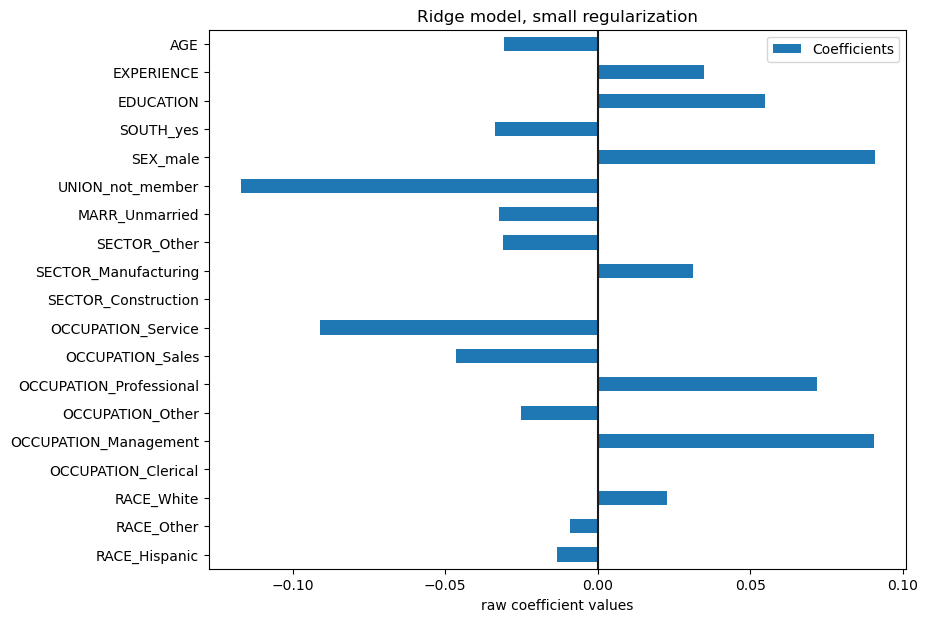

In [17]:
coefs.plot.barh(figsize=(9,7))
plt.title("Ridge model, small regularization")
plt.xlabel("raw coefficient values")
plt.axvline(x = 0, color='.1')

Indeed, from the plot above the most important factor **appears** to be UNION. Even if our intuition it should be EXPERIENCE.

Futhermore, we can compare coefficients in some way: std.dev.. It's better

In [18]:
model[:-1] # 保留预处理部分

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False))])

RACE_Hispanic               0.223312
RACE_Other                  0.336725
RACE_White                  0.386740
OCCUPATION_Clerical         0.398611
OCCUPATION_Management       0.319421
OCCUPATION_Other            0.449561
OCCUPATION_Professional     0.396697
OCCUPATION_Sales            0.246835
OCCUPATION_Service          0.355048
SECTOR_Construction         0.212972
SECTOR_Manufacturing        0.382570
SECTOR_Other                0.418105
MARR_Unmarried              0.475964
UNION_not_member            0.388784
SEX_male                    0.498814
SOUTH_yes                   0.449561
EDUCATION                   2.629689
EXPERIENCE                 12.394068
AGE                        11.779059
dtype: float64


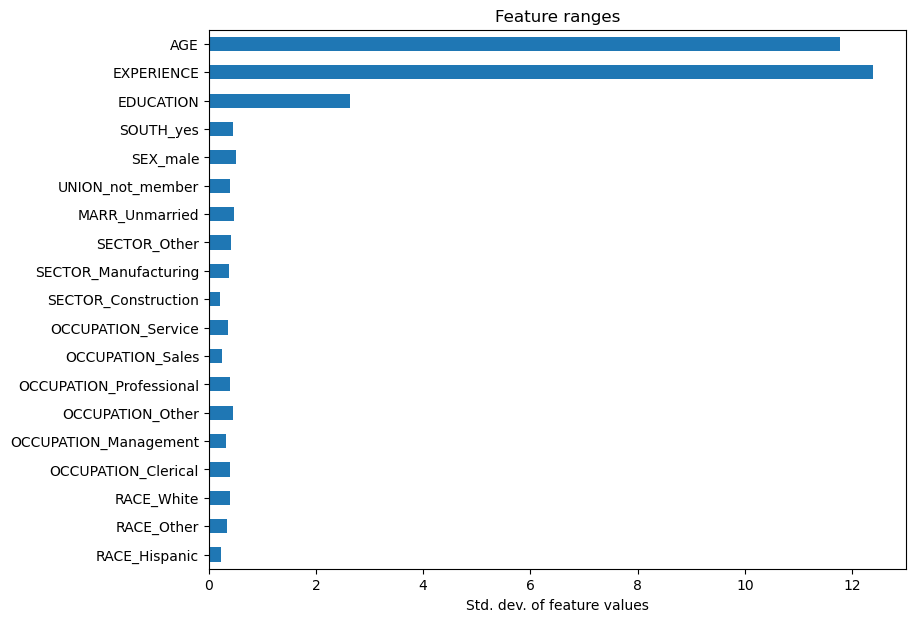

In [19]:
X_train_preprocessed = pd.DataFrame(
    model[:-1].transform(X_train), columns=feature_names
)
# 1. compute std.dev. for each feature
# 2. plot horizontal bar chart
X_train_preprocessed.std(axis=0).plot.barh(figsize=(9,7)) # ❓.plot
plt.title("Feature ranges")
plt.xlabel("Std. dev. of feature values")
print(X_train_preprocessed.std(axis=0))

$$
y = \sum{coef_i \times X_i} =
\sum{(coef_i \times std_i) \times (X_i / std_i)}
$$  
Multiplying the coefficients by the standard deviation of the related feature would reduce all the coefficients to the **same unit of measure**.   
In that way, we emphasize that the greater the **variance of a feature**, the larger the weight of the corresponding coefficient on the output, all else being equal.

Text(0.5, 1.0, 'Ridge model, small regularization')

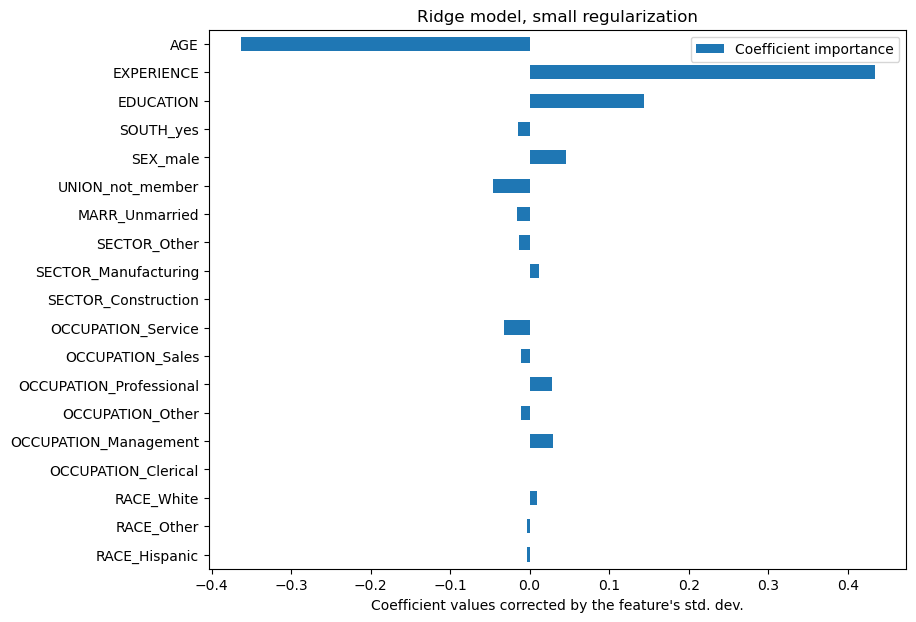

In [21]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_ * X_train_preprocessed.std(axis=0),
    columns=["Coefficient importance"],
    index=feature_names
)
coefs.plot(kind="barh", figsize=(9,7)) # ❓
plt.xlabel("Coefficient values corrected by the feature's std. dev.")
plt.title('Ridge model, small regularization')

Now, the coefficients have been scaled, we can safely compare them.

📊
The plot tell us about dependencies between a feature and target when other features remain constant, i.e.,conditional dependencies.
- Age ↑， WAGE ↓
- Experience ↓，WAGE ↑..

**🔍Marginal dependencies vs. Conditional dependencies**  
Marginal dependencies ：pairplot. 
- Just plot a feature and target, without considering other features, without fixing other features.
- Just a scatter, if exist two features have strong linear realationship, it would be disappearing in the fiting.
- It can't compare the different/compute different features, because they have different scales.

Conditional dependencies
- By the std.dev, feature values are all in normal distribution.
- Because they have same scales, we can control some features, and conclude the relationship between the a feature and target by the coefficients
- 

边界依赖（boundary dependence） 通常与分类特征（Label Encoding / One-Hot Encoding）无关，主要影响的是连续数值特征。

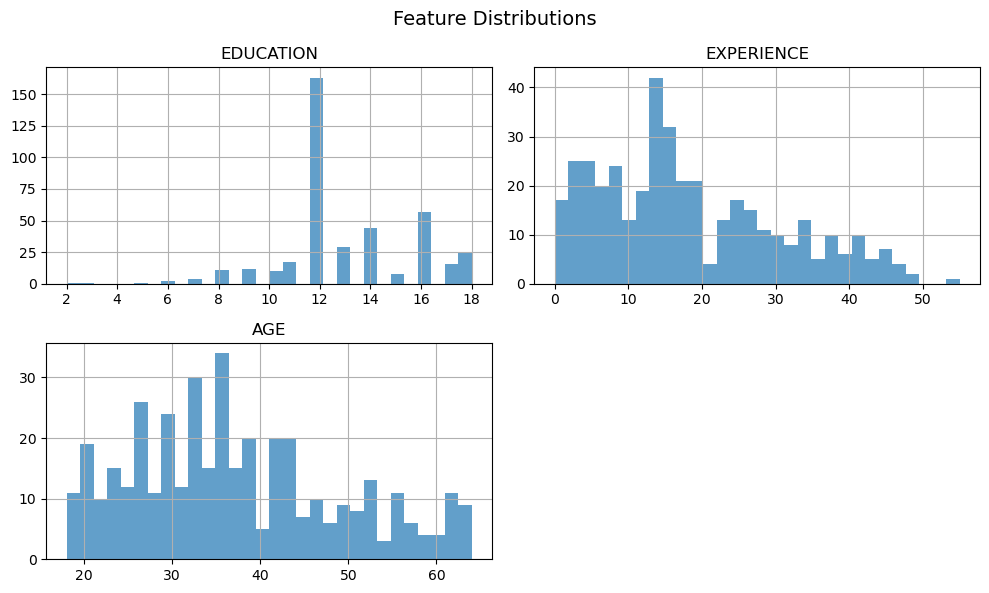

In [22]:
import numpy as np
import matplotlib.pyplot as plt

X_train_original = pd.DataFrame(
    model[:-1].transform(X_train), columns=feature_names
)
X_train_numerical_original = X_train[numerical_columns]

X_train_numerical_original.hist(bins=30, figsize=(10, 6), alpha=0.7)
plt.suptitle("Feature Distributions", fontsize=14)  # 添加总标题
plt.tight_layout()  # 自动调整布局，防止重叠

          EDUCATION    EXPERIENCE           AGE
count  4.000000e+02  4.000000e+02  4.000000e+02
mean   4.218847e-17 -1.154632e-16 -1.243450e-16
std    1.001252e+00  1.001252e+00  1.001252e+00
min   -4.205377e+00 -1.469476e+00 -1.634178e+00
25%   -3.978831e-01 -7.626085e-01 -7.841503e-01
50%   -3.978831e-01 -2.173111e-01 -1.466297e-01
75%    7.443650e-01  6.309293e-01  6.608963e-01
max    1.886613e+00  2.973689e+00  2.275948e+00


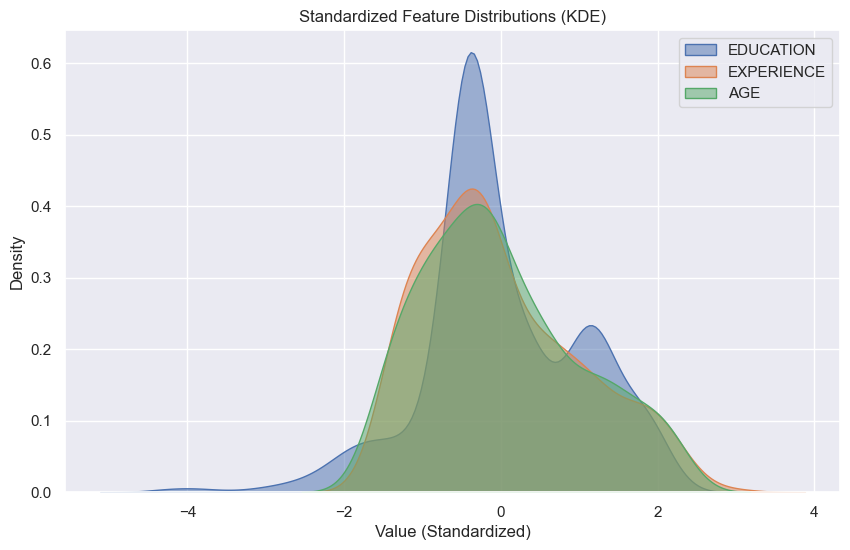

In [23]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()  # 设置 Seaborn 风格

# 标准化数据
scaler = StandardScaler()
X_train_numerical_standardized = pd.DataFrame(
    scaler.fit_transform(X_train_numerical_original),
    columns=X_train_numerical_original.columns
)

# 打印标准化后的数据描述
print(X_train_numerical_standardized.describe())

# 使用 Seaborn 绘制核密度估计图
plt.figure(figsize=(10, 6))  # 设置图像大小
for col in X_train_numerical_standardized.columns:
    sns.kdeplot(X_train_numerical_standardized[col], label=col, fill=True, alpha=0.5)

# 添加图例
plt.legend()
plt.title("Standardized Feature Distributions (KDE)")
plt.xlabel("Value (Standardized)")
plt.ylabel("Density")
plt.show()


📈
可以看到，数据归一化了。可以进行比较。

## Interpreting coefficients: being cautious about causality


## Checking the variability of the coefficients
We can check the coefficient variability through **cross-validation**: it is a form of **data perturbation** (related to resampling).

In [24]:
from sklearn.model_selection import RepeatedKFold, cross_validate
# 数据分为5块，4块训练，1块验证，5次随机划分。  共25次训练
cv =RepeatedKFold(n_splits=5,n_repeats=5,random_state=42) 
cv_model = cross_validate(
    model,
    X, # 🗼not to split trainset and testset
    y, # 
    cv = cv,
    return_estimator=True, # return every cross.val. model
    n_jobs=2 # CPU kernels
)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0) # ❓
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names,
)
coefs

,RACE_Hispanic,RACE_Other,RACE_White,OCCUPATION_Clerical,OCCUPATION_Management,OCCUPATION_Other,OCCUPATION_Professional,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Construction,SECTOR_Manufacturing,SECTOR_Other,MARR_Unmarried,UNION_not_member,SEX_male,SOUTH_yes,EDUCATION,EXPERIENCE,AGE
0,-0.003547,-0.002683,0.009371,0.001318,0.028025,-0.011708,0.026227,-0.012392,-0.029905,0.000531,0.010855,-0.012848,-0.013510,-0.044088,0.042819,-0.014302,0.140134,0.428015,-0.359926
1,-0.004324,-0.003126,0.011024,0.000345,0.028015,-0.019068,0.027272,-0.014724,-0.024661,0.008946,0.001638,-0.020583,-0.009265,-0.033194,0.053443,-0.021211,0.143335,0.363851,-0.297910
2,-0.003953,-0.002537,0.009548,-0.001528,0.029334,-0.008418,0.027596,-0.015768,-0.029650,-0.002515,0.010161,-0.005142,-0.012055,-0.028925,0.052517,-0.023798,0.143826,0.336860,-0.267547
3,-0.000364,-0.005721,0.007178,0.001672,0.027472,-0.001754,0.025711,-0.020820,-0.024916,0.001060,0.006861,-0.009584,-0.013215,-0.039093,0.036862,-0.017592,0.140537,0.300777,-0.240345
4,-0.010845,0.002542,0.016297,0.001056,0.027727,-0.010477,0.030384,-0.020990,-0.025224,0.001973,0.010445,-0.015178,-0.016504,-0.031963,0.049138,-0.014773,0.040596,-0.113693,0.155950
5,-0.005629,-0.002366,0.013031,0.000768,0.022771,-0.004603,0.025656,-0.018302,-0.023109,-0.000421,0.010218,-0.010242,-0.007597,-0.042044,0.048810,-0.024416,0.134967,0.339571,-0.276015
6,-0.004407,0.000180,0.007086,0.002306,0.031286,-0.012382,0.031863,-0.021071,-0.030438,0.005467,0.000655,-0.012617,-0.017980,-0.029244,0.048276,-0.023755,0.129513,0.320647,-0.264162
7,-0.008075,-0.000006,0.014324,-0.001771,0.027391,-0.010108,0.028667,-0.013261,-0.028958,0.000684,0.008237,-0.010225,-0.017772,-0.025015,0.046183,-0.019349,0.143287,0.352175,-0.284902
8,-0.004155,-0.001227,0.008577,-0.001146,0.025286,-0.014263,0.025883,-0.012527,-0.022404,0.006034,0.004666,-0.016596,-0.014293,-0.036369,0.048463,-0.009769,0.053734,-0.090467,0.141599
9,-0.001297,-0.007312,0.010587,0.002648,0.033709,-0.010064,0.025086,-0.019731,-0.029748,-0.000851,0.014057,-0.013342,-0.009216,-0.043134,0.043719,-0.014417,0.145145,0.407061,-0.335449


Text(0.5, 0.98, 'Ridge model, small regularization')

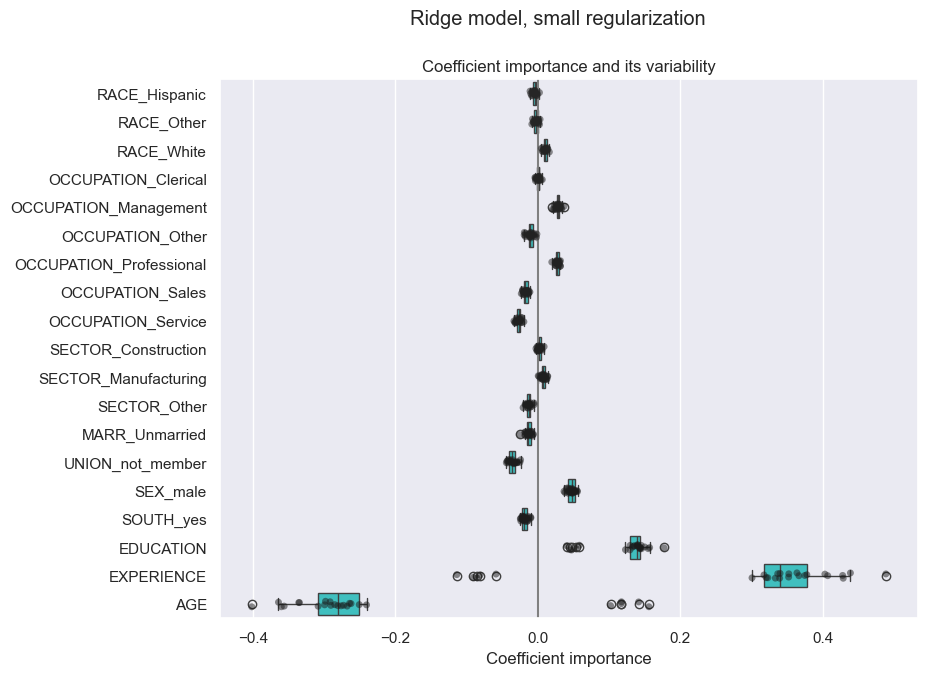

In [25]:
plt.figure(figsize=(9,7))
# 散点图
sns.stripplot( 
    data = coefs,
    orient='h', # 水平散点
    palette='dark:k', # 黑色
    alpha=0.5, # 透明
)
# 箱线图， Q1到Q3的box
sns.boxplot(
    data=coefs,
    orient='h',
    color='cyan', # 青色,
    saturation=0.5, # 饱和度
)
plt.axvline(x=0, color='.5')
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")


📈
The AGE and EXPERIENCE coefficients are affected by strong variability！

## The proplem of the variability of coefficients
It might be due to the **collinearity** between the 2 features: as AGE and EXPERIENCE vary together in the data, their effect is difficult to tease apart.

Text(0.5, 1.0, 'Co-variations of coefficients for AGE and EXPERIENCE across folds')

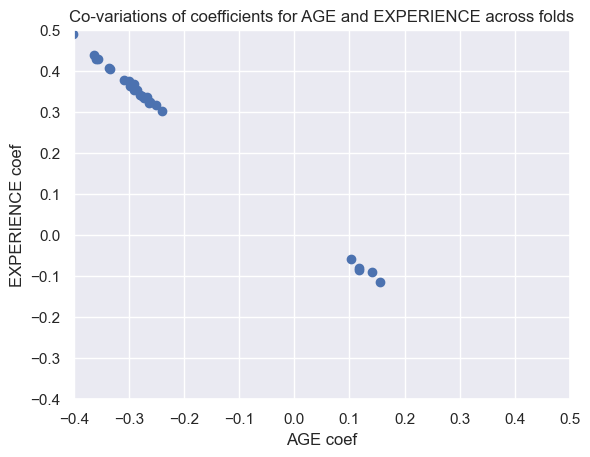

In [27]:
plt.xlabel('AGE coef')
plt.ylabel('EXPERIENCE coef')
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs['AGE'], coefs['EXPERIENCE'])
plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

To go further we remove one of the 2 features and check what is the impact on the model **stability.**

In [28]:
column_to_drop = ["AGE"]

cv_model = cross_validate(
    model,
    X.drop(columns=column_to_drop),
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_
        * est[:-1].transform(X.drop(columns=column_to_drop).iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names[:-1],
)
coefs

,RACE_Hispanic,RACE_Other,RACE_White,OCCUPATION_Clerical,OCCUPATION_Management,OCCUPATION_Other,OCCUPATION_Professional,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Construction,SECTOR_Manufacturing,SECTOR_Other,MARR_Unmarried,UNION_not_member,SEX_male,SOUTH_yes,EDUCATION,EXPERIENCE
0,-0.003593,-0.002656,0.009413,0.001098,0.027978,-0.011691,0.026713,-0.012435,-0.030047,0.000570,0.010750,-0.012826,-0.013150,-0.044006,0.042445,-0.014454,0.060582,0.049317
1,-0.004357,-0.003118,0.011075,0.000167,0.027982,-0.019070,0.027711,-0.014743,-0.024796,0.008999,0.001546,-0.020557,-0.009005,-0.033103,0.053095,-0.021342,0.076528,0.050360
2,-0.003993,-0.002520,0.009602,-0.001678,0.029307,-0.008439,0.027962,-0.015808,-0.029764,-0.002507,0.010101,-0.005127,-0.011796,-0.028864,0.052249,-0.023900,0.081485,0.053518
3,-0.000412,-0.005685,0.007221,0.001503,0.027444,-0.001768,0.026057,-0.020852,-0.025028,0.001081,0.006793,-0.009570,-0.012939,-0.039078,0.036578,-0.017688,0.086398,0.046488
4,-0.010846,0.002542,0.016296,0.001057,0.027728,-0.010475,0.030385,-0.020989,-0.025223,0.001973,0.010445,-0.015178,-0.016504,-0.031963,0.049138,-0.014773,0.073913,0.051704
5,-0.005647,-0.002349,0.013050,0.000571,0.022735,-0.004614,0.026095,-0.018335,-0.023247,-0.000381,0.010142,-0.010200,-0.007295,-0.042016,0.048485,-0.024503,0.074251,0.047320
6,-0.004436,0.000185,0.007118,0.002152,0.031252,-0.012385,0.032206,-0.021105,-0.030538,0.005500,0.000573,-0.012636,-0.017737,-0.029187,0.048003,-0.023865,0.068906,0.041878
7,-0.008128,0.000020,0.014392,-0.001918,0.027355,-0.010075,0.029053,-0.013299,-0.029065,0.000709,0.008142,-0.010192,-0.017479,-0.024976,0.045884,-0.019454,0.079474,0.052339
8,-0.004155,-0.001226,0.008577,-0.001141,0.025291,-0.014257,0.025889,-0.012524,-0.022399,0.006035,0.004667,-0.016594,-0.014293,-0.036369,0.048463,-0.009769,0.085219,0.058876
9,-0.001357,-0.007284,0.010664,0.002446,0.033678,-0.010061,0.025523,-0.019762,-0.029879,-0.000836,0.013997,-0.013284,-0.008912,-0.043070,0.043364,-0.014539,0.070992,0.051418


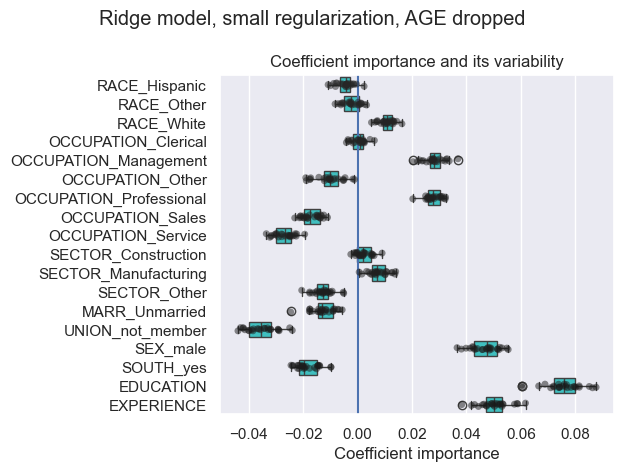

In [29]:
sns.stripplot(
    data=coefs,
    orient='h',
    palette='dark:k', # 黑色
    alpha=0.5, # 透明
)
sns.boxplot(
    data=coefs,
    orient='h',
    color='cyan', # 青色,
    saturation=0.5, # 饱和度
)
plt.axvline(x=0)
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.suptitle("Ridge model, small regularization, AGE dropped")
plt.tight_layout()

📈 This show EXPERIENCE coefs have a more stability (reduced variability) .

## Preprocessing numerical variables
 we could  choose to scale numerical values before training the model.   
 This can be useful when we apply a similar amount of regularization to all of them in the ridge.

so we redefined the preprocessor.

In [30]:
from sklearn.preprocessing import StandardScaler
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), categorical_columns),
    (StandardScaler(), numerical_columns)
)

In [31]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

**Again**, we check the perfomance. the median absolute error , R suqared coefficient

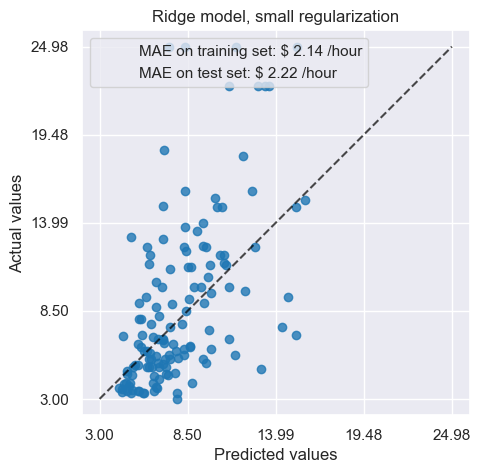

In [32]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
fig, ax = plt.subplots(figsize =(5,5))
display = PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred,
    kind='actual_vs_predicted',
    ax = ax
)
ax.set_title('Ridge model, small regularization')
scores = {
    "MAE on training set": f"$ {mae_train:.2f} /hour",
    "MAE on test set": f"$ {mae_test:.2f} /hour"
}
for name, score in scores.items():
    ax.plot(
        [],
        [],
        " ",
        label=f"{name}: {score}"
    )
ax.legend(loc="upper left")

For the coefficient analysis, scaling is not needed at this time ,because it was performed in the preprocesser.

In [33]:
model[-1].regressor_.coef_

array([-1.35165845e-02, -9.07289299e-03,  2.25964495e-02,  1.28244300e-04,
        9.06107877e-02, -2.50185336e-02,  7.20465641e-02, -4.65530613e-02,
       -9.09700762e-02, -1.70971634e-04,  3.12818248e-02, -3.09984468e-02,
       -3.24046188e-02, -1.17153811e-01,  9.08084233e-02, -3.38233805e-02,
        1.43662632e-01,  4.33314415e-01, -3.63130602e-01])

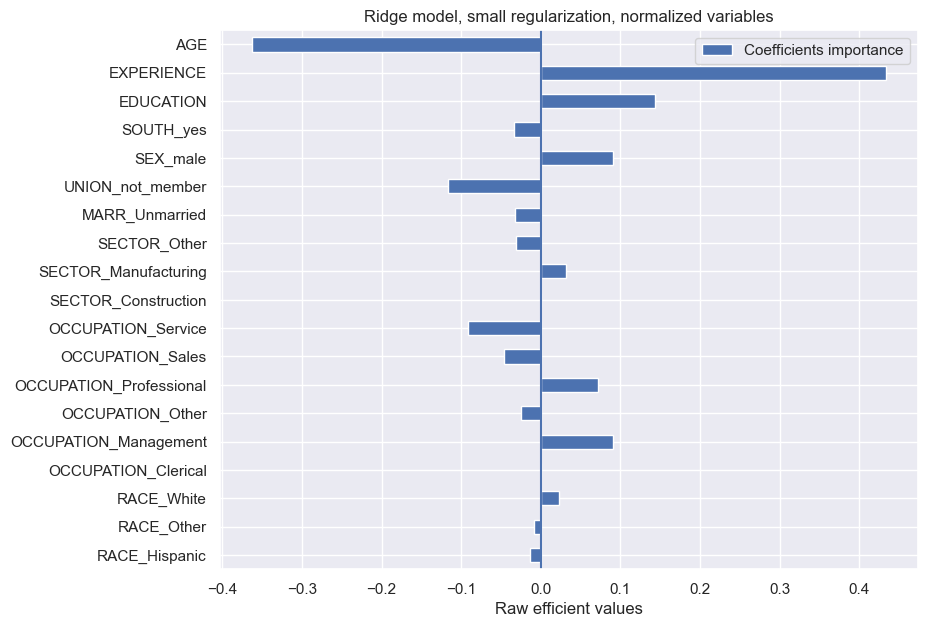

In [34]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=['Coefficients importance'],
    index=feature_names
)
coefs.plot.barh(figsize=(9,7))
plt.title('Ridge model, small regularization, normalized variables')
plt.xlabel('Raw efficient values')
plt.axvline(x=0)

Now, we inspect the coefficients across several cross-validation folds. But we **don't need to scale the coefficients** by the std.dev. by the feature values since this scaling was already done in the preprocessing step. (In the other hand, the coefficients are already std.dev.)

In [35]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv= cv,
    return_estimator=True,
    n_jobs=2
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model['estimator']],
    columns= feature_names
)

coefs

,RACE_Hispanic,RACE_Other,RACE_White,OCCUPATION_Clerical,OCCUPATION_Management,OCCUPATION_Other,OCCUPATION_Professional,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Construction,SECTOR_Manufacturing,SECTOR_Other,MARR_Unmarried,UNION_not_member,SEX_male,SOUTH_yes,EDUCATION,EXPERIENCE,AGE
0,-0.016419,-0.007964,0.024358,0.003301,0.090407,-0.026376,0.065412,-0.050047,-0.082710,0.002497,0.028757,-0.031327,-0.028343,-0.114676,0.085836,-0.031737,0.140134,0.428015,-0.359926
1,-0.019559,-0.009331,0.028677,0.000895,0.094091,-0.041890,0.069910,-0.055123,-0.068204,0.044557,0.004232,-0.048913,-0.019439,-0.085907,0.107290,-0.046616,0.143335,0.363851,-0.297910
2,-0.017160,-0.007692,0.024838,-0.004213,0.095496,-0.018370,0.068476,-0.059086,-0.082573,-0.013318,0.025486,-0.012217,-0.025456,-0.075234,0.105431,-0.052679,0.143826,0.336860,-0.267547
3,-0.001661,-0.017469,0.019089,0.004274,0.090373,-0.003856,0.064119,-0.085539,-0.069349,0.005027,0.017731,-0.023072,-0.027768,-0.100676,0.074033,-0.038753,0.140537,0.300777,-0.240345
4,-0.051385,0.007783,0.043567,0.002810,0.092219,-0.022747,0.077555,-0.080993,-0.068210,0.008556,0.026522,-0.035182,-0.034871,-0.084981,0.098587,-0.031987,0.066988,0.017324,0.032416
5,-0.027286,-0.006994,0.034259,0.001958,0.073416,-0.010145,0.067046,-0.070565,-0.062096,-0.001982,0.026122,-0.024127,-0.016016,-0.107239,0.098074,-0.054181,0.134967,0.339571,-0.276015
6,-0.019156,0.000534,0.018601,0.006067,0.104997,-0.027467,0.079389,-0.082504,-0.080475,0.028695,0.001597,-0.030426,-0.037665,-0.076066,0.096583,-0.052583,0.129513,0.320647,-0.264162
7,-0.037346,-0.000020,0.037444,-0.004611,0.087585,-0.022095,0.071547,-0.050297,-0.082130,0.003146,0.021198,-0.024161,-0.037859,-0.067185,0.092678,-0.041530,0.143287,0.352175,-0.284902
8,-0.018792,-0.003746,0.022665,-0.002964,0.083163,-0.031214,0.064527,-0.049803,-0.063605,0.027297,0.012326,-0.039753,-0.030337,-0.094124,0.097293,-0.021468,0.076868,0.019266,0.037556
9,-0.005871,-0.022021,0.027705,0.006687,0.114555,-0.022168,0.062623,-0.077267,-0.083943,-0.004250,0.035543,-0.031433,-0.019098,-0.112296,0.088091,-0.032095,0.145145,0.407061,-0.335449


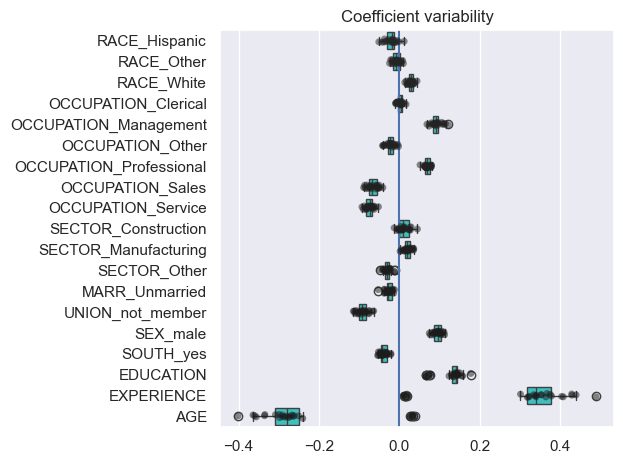

In [36]:
sns.stripplot(
    data=coefs,
    orient='h',
    palette='dark:k', # 黑色
    alpha=0.5, # 透明
)
sns.boxplot(
    data=coefs,
    orient='h',
    color='cyan', # 青色,
    saturation=0.5, # 饱和度
)
plt.axvline(x=0)
plt.title('Coefficient variability')
plt.tight_layout()

The result is similar to the non-normalized case . SO it's ok.

## Linear models with regularization
- Ridge regression is more often used with a non-negligible regularization.  
- RidgeCV applies cv. in order to determine which value of the alpha. is best.

In [37]:
from sklearn.linear_model import RidgeCV
alphas = np.logspace(-10, 10, 21)
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)
model.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RidgeCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]))))])

In [38]:
model[-1].regressor_.alpha_

np.float64(10.0)

Then we check the quality of the predictions .

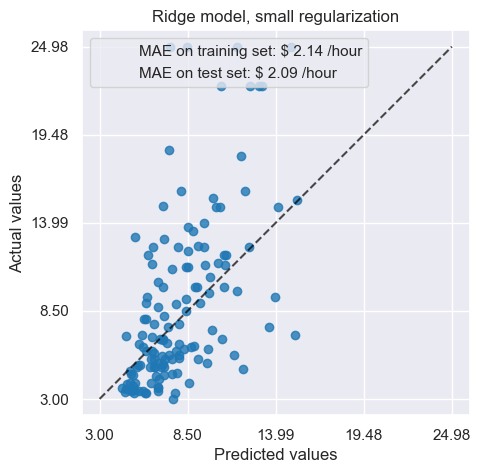

In [39]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
fig, ax = plt.subplots(figsize =(5,5))
display = PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred,
    kind='actual_vs_predicted',
    ax = ax
)
ax.set_title('Ridge model, small regularization')
scores = {
    "MAE on training set": f"$ {mae_train:.2f} /hour",
    "MAE on test set": f"$ {mae_test:.2f} /hour"
}
for name, score in scores.items():
    ax.plot(
        [],
        [],
        " ",
        label=f"{name}: {score}"
    )
ax.legend(loc="upper left")

the predict error is similar to previous one.

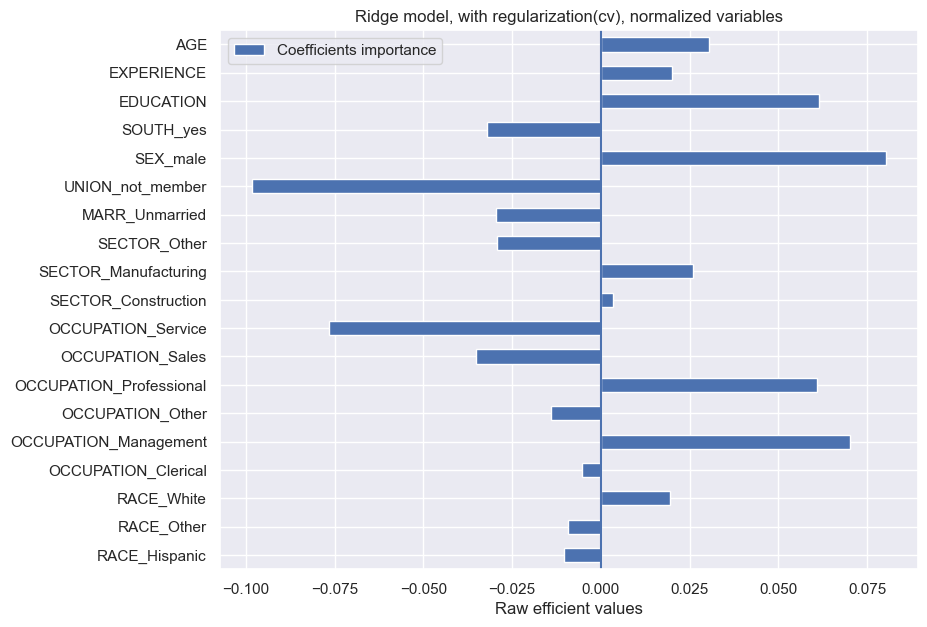

In [40]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=['Coefficients importance'],
    index=feature_names
)
coefs.plot.barh(figsize=(9,7))
plt.title('Ridge model, with regularization(cv), normalized variables')
plt.xlabel('Raw efficient values')
plt.axvline(x=0)


❗**The coefficients are significantly different.**.  We can inspect that AGE and EXPERIENCE have less influence on the prediction.
- The regularization **reduces** the influence of the correlated variables on the model. **Because the regularization (L1, L2) can share(penalize/average) the all wights for the model** ,this can reduce the some big weight. So neither alone have strong weights,
- By the regularization , the weights are more stable.

In [41]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv= cv,
    return_estimator=True,
    n_jobs=2
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model['estimator']],
    columns= feature_names
)



Text(0.5, 1.0, 'Co-variations of coefficients for AGE and EXPERIENCE across cv')

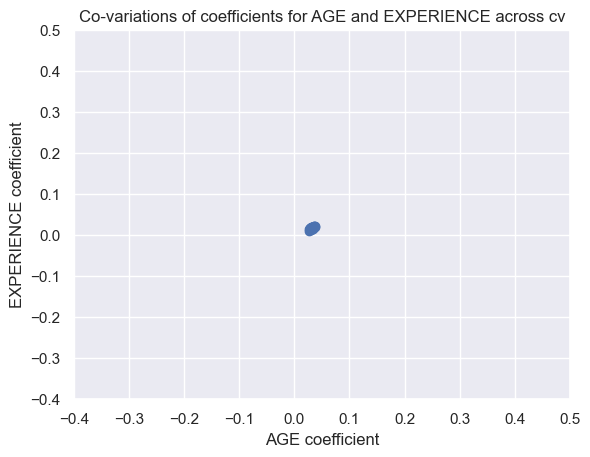

In [42]:
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.xlabel("AGE coefficient")
plt.ylabel("EXPERIENCE coefficient")
plt.scatter(coefs['AGE'], coefs['EXPERIENCE'])
plt.title('Co-variations of coefficients for AGE and EXPERIENCE across cv')

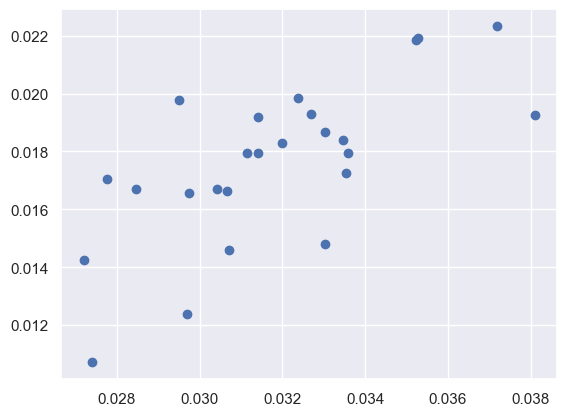

In [43]:
plt.scatter(coefs['AGE'], coefs['EXPERIENCE'])


📈 We can inspect that 
- AGE, EXPERIENCE coefficients are vevy small, they all have less influence.
- The co-relation of them are't direct.

## Linear models with sparse coefficients
Another way to take into cor. var. is sparse coefficietns. 
In the previous Ridge estimator we dropped the AGE column manually.

Lasso cestimate sparse coefficients. LassoCV can cv. to determine best $\alpha$.

In [47]:
from sklearn.linear_model import LassoCV
alphas = np.logspace(-10, 10, 21)
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=100_000), 
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)
_ = model.fit(X_train, y_train)

In [49]:
model[-1].regressor_.alpha_

np.float64(0.001)

Check the quality of predictions.

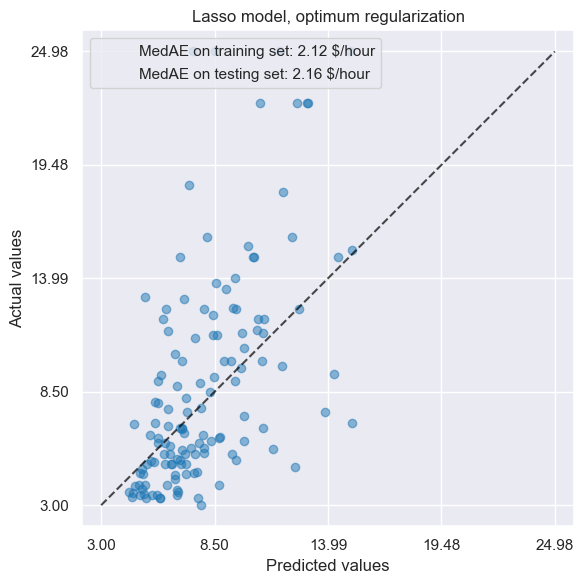

In [51]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(6, 6))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Lasso model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

The result is similar.


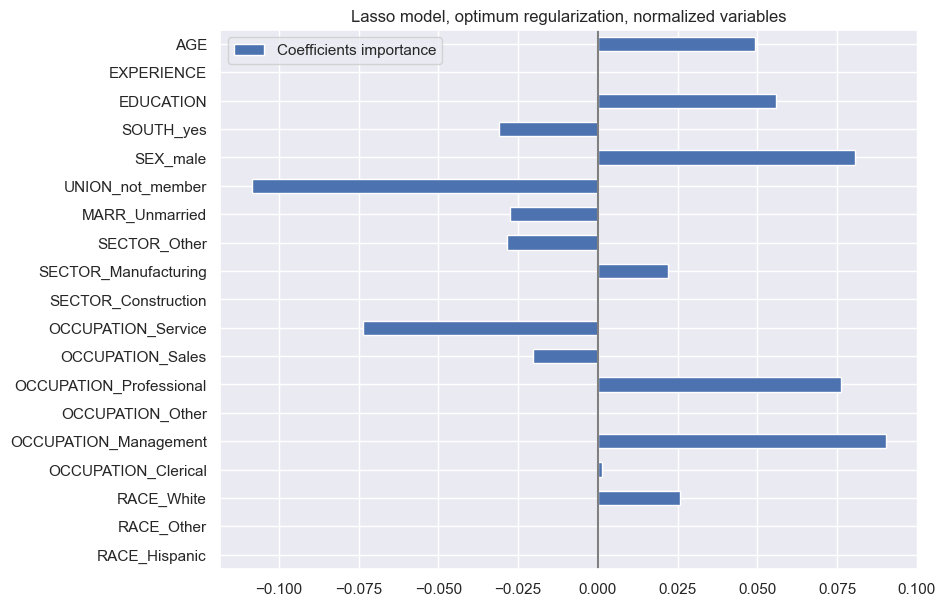

In [53]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Lasso model, optimum regularization, normalized variables")
plt.axvline(x=0, color=".5")


📊 In this model, EXPERIENCE coef. have been zero.  When there are some cor. feature, Lasso always only leave one feature, set other coefs. zero.

Indeed, we look at the variability of coef. by CV.  
- LassoCV只是选取最好$\alpha$, 系数的稳定性需要自己CV

In [55]:
cv_model = cross_validate( # ❓
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

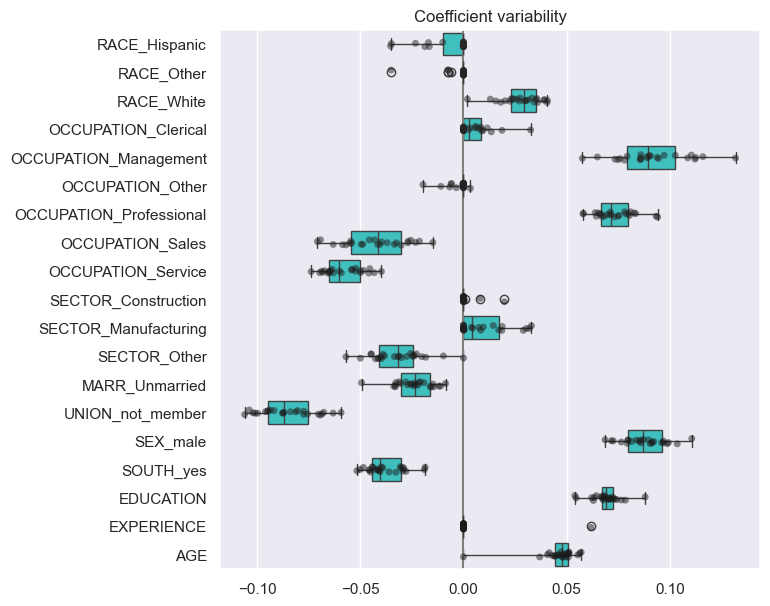

In [57]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=100)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

## Wrong causal interpretation

## Lessons learned

- Coefficients must be scaled to the same unit of measure by the std.dev.
- Interpreting casusality is difficult when there are confounding(unobserved) effect. Must be cautious when making conclusions about causality
- ..
- 